In [1]:
import warnings
warnings.filterwarnings('ignore')

## Introduction

The last two days we have learnt how to deal with seismic data using python and some available libraries. Now, you have confident in working with various libraries as well as writing your own code if necessary! (rememmber we are not here to invent the wheel!) Today, we will go through some applications of machine learning in sesmic data analysis. A literature search was conducted to identify the relevant studies and articles based on abstract
and title words and citation relation. Data were collected from the Web of Science Core
Correction in the period of 1900–2020.Various keywords were used to increase the chance of
finding more relevant publications: "Seismic + machine learning", "Seismic + data science", ....
Let's take a look at some analysis:

<img src="../data/years.jpg" width=500 height=500 />

<div class="alert alert-block alert-danger">
You can see the number of publications has been increased exponentially! <div>

<img src="../data/keywords1.png" width=500 height=500 />

<div class="alert alert-block alert-danger">
Here is the most repeated keywords clustered <div>

<div class="alert alert-block alert-info">
I suggest you to do some data analysis with job ads websites to see how data science in seismic is getting popular in job anouncements over the years </div>

Today we will look at one example together! We will show you a very basic solution for each and expect you to improve them in a group. Note that the data here are not perfect and good, it is just more of a reminder of what you have learnt last term not a real machine learning project!
For reading more please check bellow links:
- [Seismic Data Exploration](https://www.kaggle.com/code/jsaguiar/seismic-data-exploration)
- [Intro to seismic, salt](https://www.kaggle.com/code/bit3125/intro-to-seismic-salt-and-how-to-geophysi-07a2b8)
- You worked with earthquacke data damage in Machine Learning and Data Science module with Cedric, if you are interested more on working with this data feel free to send a message in teams! 
[Earthquakes And Tectonic Plates: Seismic Analysis](https://www.kaggle.com/code/karnikakapoor/earthquakes-and-tectonic-plates-seismic-analysis)

## Practical 1: Mapping salt in 2-D seismic image

In [ ]:
# !pip install pycm
# !pip install livelossplot
# !pip install torchvision
# !pip install torchsummary
# !pip install torch
# !pip install progressbar

In [1]:
%pylab inline

from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision import models

from progressbar import ProgressBar

In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True


DEVICE = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    DEVICE = 'cuda'
else:
    print("No GPU available!")

DEVICE

SEED = 42
set_seed(SEED)

In [2]:
data = mpimg.imread('../data/seismic.tif')

In [3]:
data.shape

(1036, 2350, 3)

In [4]:
mask = mpimg.imread('../data/mask.tif')

In [5]:
mask.shape

(1036, 2350)

In [6]:
# Remmeber to scale your data manually!
data = data[:,:,:1]/255
mask = (mask-mask.min())/(mask.max()-mask.min())

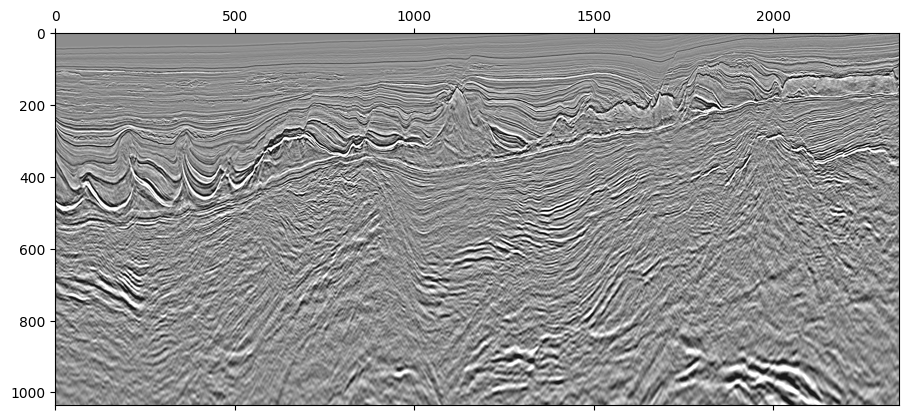

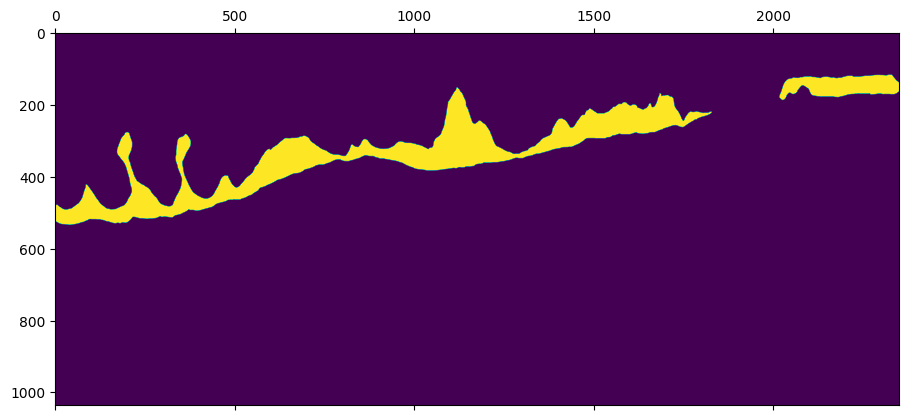

In [7]:
plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

So now we have one image with a mask, but we need many more examples to train a deep learning model. Of course, we could label more examples, but that takes time and additional data. Let's say we have neither of those. In this case, we can split up our image and mask in to many pairs of small patches. So let's do that:

In [9]:
def patchify(data, mask, patch_num, dim):

  X = np.empty((patch_num, *dim))
  y = np.empty((patch_num,2))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not at the edge)   
      x_n = random.randint(dim[1]//2,x_max-dim[1]//2)
      t_n = random.randint(dim[0]//2,t_max-dim[0]//2)
      
      # Extract data patch around point   
      X[n,:,:,0] = data[t_n-dim[0]//2:t_n+dim[0]//2,x_n-dim[1]//2:x_n+dim[1]//2,0]
      
      # Note label of point (one-hot-encoding) zero for non salt and one for salt  
      y[n,0] = mask[t_n,x_n]
      y[n,1] = 1 - mask[t_n,x_n]

  return X, y

In [137]:
number_train = 5000                             # Number of training examples
number_test   = 1000                             # Number of validation examples
dim          = (64,64,1)                        # Size of examples

X_train, y_train = patchify(data[:,:1200], mask[:,:1200], patch_num=5000, dim=dim)
X_val, y_val = patchify(data[:,:1200], mask[:,:1200], patch_num=1000, dim=dim)
X_test, y_test   = patchify(data[:,1200:], mask[:,1200:], patch_num=1000, dim=dim)

In [133]:
X_test.shape

(1000, 64, 64, 1)

In [134]:
data.shape

(1036, 2350, 1)

In [132]:
X_train, y_train = patchify(X_train[:,:1200], X_train[:,:1200], num=500, dim=dim)

(5000, 64, 64, 1)

In [11]:
X_train.shape

(5000, 64, 64, 1)

In [19]:
y_train

(5000, 2)

In [56]:
for i in y_train:
    if not np.allclose(i, np.array([0., 1.])):
       pass
    elif not np.allclose(i, np.array([1., 0.])):
        pass
    else:
        print('d')

In [46]:
# X_train[0].shape
np.unique(y_train[:])

array([0.        , 0.05882353, 0.1254902 , 0.18823529, 0.24705882,
       0.30980392, 0.31372549, 0.37254902, 0.37647059, 0.49803922,
       0.50196078, 0.62352941, 0.62745098, 0.68627451, 0.69019608,
       0.75294118, 0.81176471, 0.8745098 , 0.94117647, 1.        ])

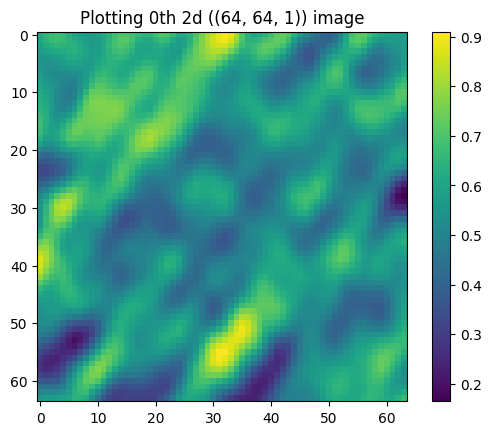

In [31]:
# we can modify the dims of the "2d squares"

fig, ax = plt.subplots()

idx = 0

obj = ax.imshow(X_train[0],  cmap='viridis')
ax.set_title(f'Plotting {idx}th 2d ({dim}) image')

In [231]:
class CustomImageDataset(Dataset):
    def __init__(self, data, targets, transform):
        """Initialisation."""
        # set inputs
        self.data = data
        self.targets = targets
        self.transform = transform

        # handle data type on instantiation.
        if isinstance(self.data, np.ndarray):
            # enforce dtype np.uint8
            self.data = self.data.astype(np.uint8)
            # extend to 3 channels
            self.data = np.repeat(self.data, 3, axis=3)
        elif isinstance(self.data, torch.Tensor):
            # convert tensor to numpy and np.uint8
            self.data = self.data.numpy().astype(np.uint8)
        else:
            raise TypeError("Data needs to be either an \
            np.ndarray \or torch.Tensor of images \
            with the shape (num_images, h, w).")

    def __getitem__(self, idx):
        """Get raw data using idx and apply transforms to output a processed image tensor."""
        image, target = self.data[idx].copy(), self.targets[idx].copy()

        # print(target, target.shape)

        if self.transform:
            image = self.transform(image)

        # basic assertions to ensure transform worked.
        assert isinstance(image, torch.Tensor)

        return image, int(target[0])

    def __len__(self):
        return len(self.data)

In [249]:
transform = transforms.Compose(transforms=[transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.3)])
transform

Compose(
    ToTensor()
    RandomHorizontalFlip(p=0.3)
)

In [250]:
dummy = CustomImageDataset(data=X_train, targets=y_train, transform=transform)

In [251]:
dummy.__getitem__(0)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [252]:
train_dataset = CustomImageDataset(data=X_train,
                                      targets=y_train,
                                      transform=transform)

val_dataset = CustomImageDataset(data=X_val,
                                    targets=y_val,
                                    transform=transform)

test_dataset = CustomImageDataset(data=X_test,
                                     targets=y_test,
                                     transform=transform)

print("\nTensor Datasets:")
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())


Tensor Datasets:
5000
1000
1000


In [253]:
train_dataset.__getitem__(0)[0].shape

torch.Size([3, 64, 64])

In [261]:
def set_parameter_requires_grad(model, requires_grad=False):
    """https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html"""
    for param in model.parameters():
        param.requires_grad = requires_grad
    return None

def get_params_to_update(model):
    """ Returns list of model parameters that have required_grad=True"""
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

In [256]:
batch_size = 32
num_workers = 0

In [257]:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=num_workers,
                                          shuffle=False)

train_loader.dataset.__len__(), val_loader.dataset.__len__(), test_loader.dataset.__len__()
     

(5000, 1000, 1000)

In [258]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(X.view(-1, 3, 64, 64))
        loss = criterion(output, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(output, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(DEVICE), y.to(DEVICE)
            a2 = model(X.view(-1, 3, 64, 64))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(DEVICE), y.to(DEVICE)
            a2 = model(X.view(-1, 3, 64, 64))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)


def plot_confusion_matrix(model, device, dataloader):
    # trained model (straight from training)
    y_pred, y = evaluate(model, device, dataloader)  # predictions with the final trained model
    accuracy1 = accuracy_score(y_true=y, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay.from_predictions(y_true=y,
                                            y_pred=y_pred,
                                            ax=ax,
                                            colorbar=False,
                                            cmap='bone_r')
    plt.show()

    print("Metrics:")
    print(f"Accuracy score: {accuracy1}")

In [259]:
training_config = {
    'n_epochs': 20,
    'lr': 1e-4,
    'criterion': nn.CrossEntropyLoss(),
}

training_config

{'n_epochs': 20, 'lr': 0.0001, 'criterion': CrossEntropyLoss()}

In [263]:
set_seed(42)

model = models.resnet18(pretrained=True).to(DEVICE)
set_parameter_requires_grad(model, requires_grad=False)
model.fc = nn.Linear(model.fc.in_features, 2).to(DEVICE)  # newly initialised layers automatically have requires_grad=True
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

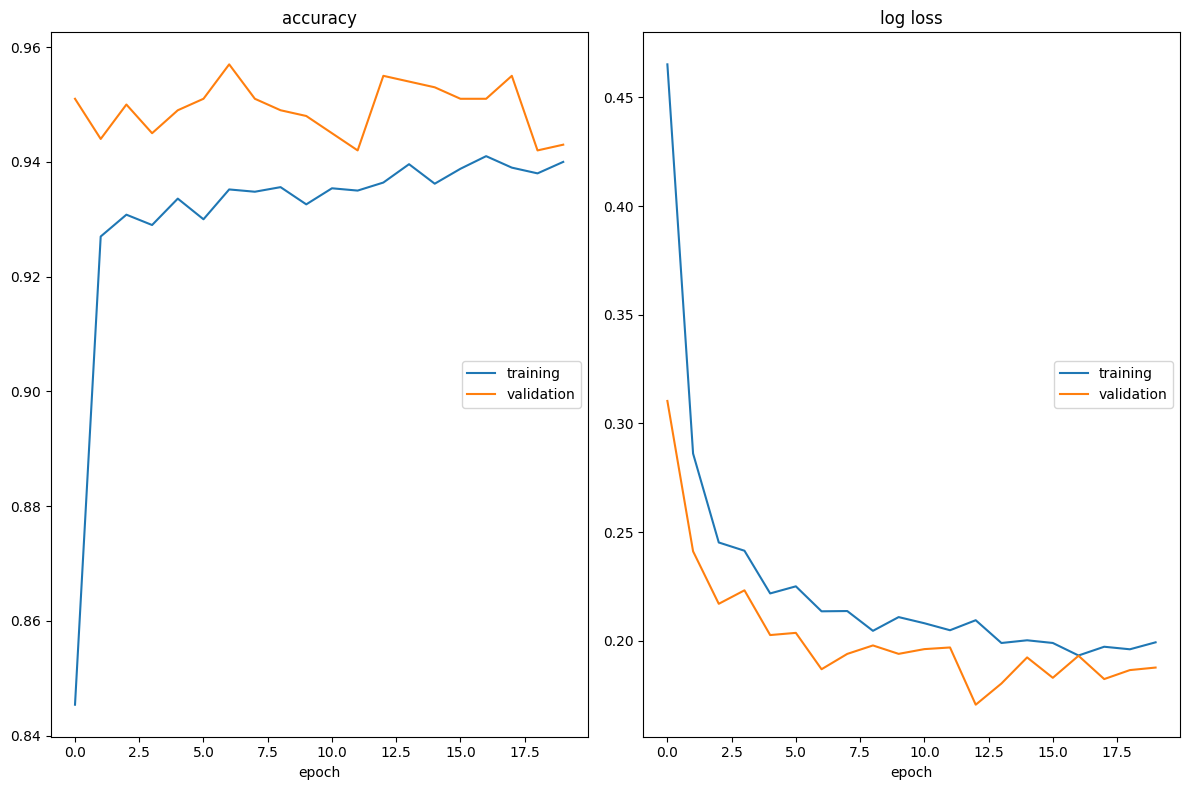

accuracy
	training         	 (min:    0.845, max:    0.941, cur:    0.940)
	validation       	 (min:    0.942, max:    0.957, cur:    0.943)
log loss
	training         	 (min:    0.193, max:    0.465, cur:    0.199)
	validation       	 (min:    0.171, max:    0.310, cur:    0.188)
Avg. Test Loss: 0.184  Avg. Test Accuracy: 0.941



In [264]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=training_config["lr"],
        )

liveloss = PlotLosses()
for epoch in range(training_config["n_epochs"]):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

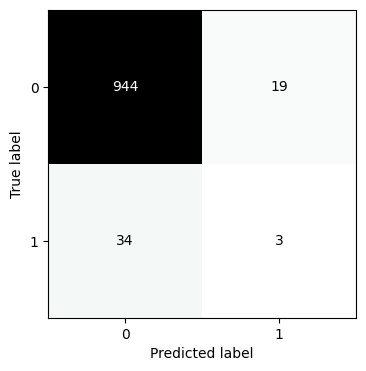

Metrics:
Accuracy score: 0.947


In [282]:
# confusion matrix
plot_confusion_matrix(model, device=DEVICE, dataloader=test_loader)

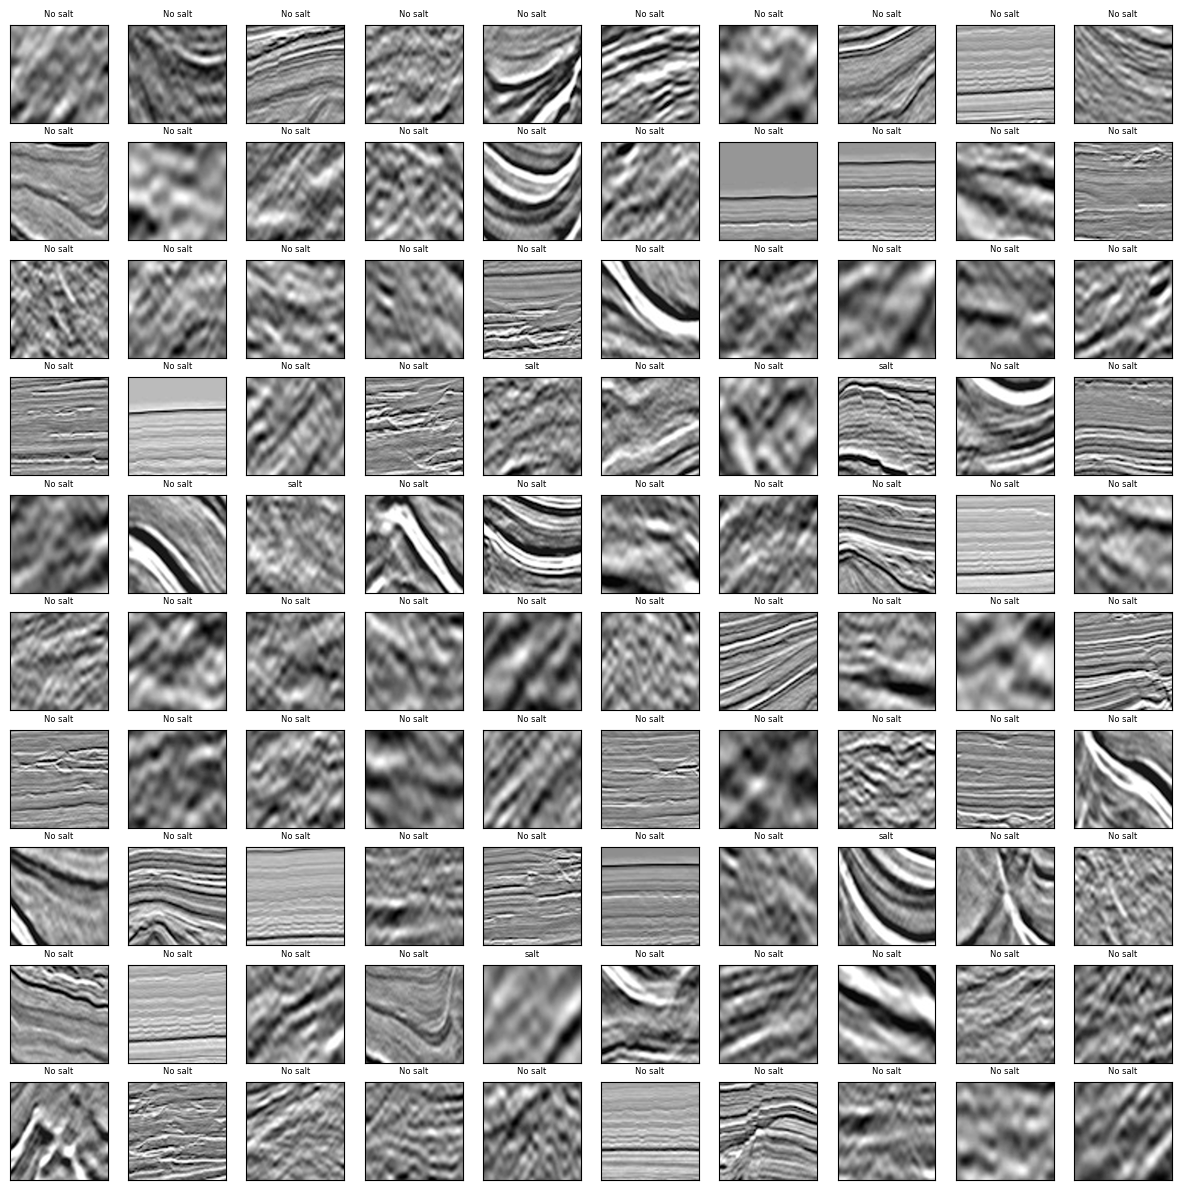

In [37]:
fig, axs = plt.subplots(10, 10, figsize=(15,15))

k = 0
for n in range(10):
  for m in range(10):
    axs[n,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])
    k += 1
    if y_train[k, 0] == 1:
      axs[n,m].set_title('salt', fontsize=6)
    else:
      axs[n,m].set_title('No salt', fontsize=6)

In [57]:
model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [58]:
cnn_training = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 5s 28ms/step - loss: 0.2760 - binary_accuracy: 0.9212 - val_loss: 0.2207 - val_binary_accuracy: 0.9620
Epoch 2/10
157/157 [==============================] - 4s 28ms/step - loss: 0.2110 - binary_accuracy: 0.9346 - val_loss: 0.2643 - val_binary_accuracy: 0.9170
Epoch 3/10
157/157 [==============================] - 4s 27ms/step - loss: 0.1886 - binary_accuracy: 0.9438 - val_loss: 0.1752 - val_binary_accuracy: 0.9440
Epoch 4/10
157/157 [==============================] - 4s 28ms/step - loss: 0.1611 - binary_accuracy: 0.9468 - val_loss: 0.1710 - val_binary_accuracy: 0.9390
Epoch 5/10
157/157 [==============================] - 4s 27ms/step - loss: 0.1349 - binary_accuracy: 0.9546 - val_loss: 0.2333 - val_binary_accuracy: 0.9080
Epoch 6/10
157/157 [==============================] - 5s 29ms/step - loss: 0.1156 - binary_accuracy: 0.9602 - val_loss: 0.1710 - val_binary_accuracy: 0.9400
Epoch 7/10
157/157 [==============================] - 4s 2

In [59]:
test_loss = model.evaluate(X_test, y_test) 

32/32 [==============================] - 0s 8ms/step - loss: 0.2694 - binary_accuracy: 0.9330


In [64]:
cnn_score = model.evaluate(X_test, y_test)[1]
cnn_score

32/32 [==============================] - 0s 9ms/step - loss: 0.2694 - binary_accuracy: 0.9330


0.9330000281333923

In [65]:
history = cnn_training.history

In [66]:
history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

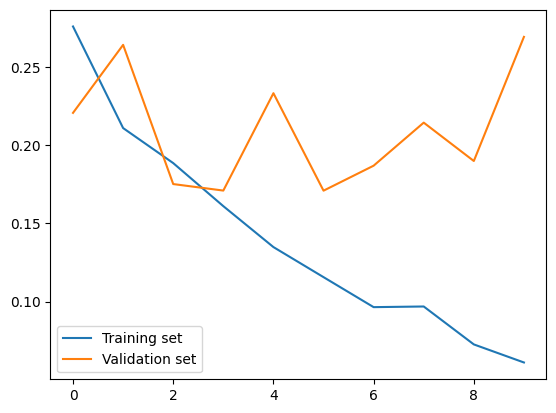

In [67]:
plt.plot(cnn_training.history['loss'], label='Training set')
plt.plot(cnn_training.history['val_loss'], label='Validation set')
plt.legend()

In [273]:
(t_max, x_max, _) = data.shape
result            = np.zeros((t_max,x_max,2))
batch             = np.zeros((t_max-dim[1], *dim))

m = 0
n = 0
for x in range(dim[0]//2,x_max-dim[0]//2): 
  stdout.write("\r%d" % m)
  stdout.flush()
  m = m + 100/(x_max-dim[0])

  for t in range(dim[1]//2,t_max-dim[1]//2):
    batch[n,:,:,0] = data[t-dim[1]//2:t+dim[1]//2, x-dim[0]//2:x+dim[0]//2, 0] 
    n = n + 1

  # result[dim[1]//2:t_max-dim[1]//2,x,:] = model.predict_on_batch(batch)
  result[dim[1]//2:t_max-dim[1]//2,x,:] = model(batch)

  n = 0

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()

0

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


### END OF SCRIPT